# Uploading to Google Cloud

This will upload to Google Cloud and create a VirtualiZarr json file that we can use to lazy load all the data without making it a Zarr because R doesn't play nice with Zarr. Why do we want Zarr? Zarr stored in a cloud-bucket is optimized for cloud-native, parallel, and scalable processing with tools like Dask, Xarray, and machine-learning libraries. Since that is our eventual goal, we want the data stored in the optimized format for the future tasks.

Scroll down to the bottom to see the actual code I ran that creates proper netcdfs and Zarr with attributes needed for fully documented and cf-compliant data files.

### Prerequisites

The `py-rocket-geospatial-2` image on the NMFS Openscapes JuptyerHub is already set up with this.

* `pip install google-cloud-storage`
* `sudo apt-get install google-cloud-sdk`

You need to have the Storage Admin role on the bucket or on the folder of a bucket. For example, if you will be uploading to the [NOAA Fisheries Google NODD Public Buckets](https://www.noaa.gov/nodd/datasets#NMFS), you will need to be added as a Storage Admin role to a specific folder.

## Authenticate

Run the following in a terminal. It will open and you authenticate there. It will save `application_default_credentials.json` to `~/.config/gcloud`. If you do not have `google-cloud-sdk` installed, you can install somewhere (like locally) and then copy that file and create it here (in hub or whereever you are running this tutorial).

## Upload the netcdf files

We created these netcdf files in `streamflow_processing.ipynb`. First we set up the bucket client.

In [1]:
# set up bucket client
# stop annoying warnings
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

from google.cloud import storage
from pathlib import Path

# === Set these ===
bucket_name = "nmfs_odp_nwfsc"

# Create client and bucket
client = storage.Client(project="noaa-gcs-public-data")
bucket = client.bucket(bucket_name)

## Upload the files

### Start with a test file

In [ ]:
# Set the file you want to test with
test_file = Path("../netcdf/daily_mean_2018.nc")  # change this if using a different file
destination_prefix = "CB/nwm_daily_means/wr1718/streamflow/netcdf"

# Create blob and upload
blob_path = f"{destination_prefix}/{test_file.name}"
blob = bucket.blob(blob_path)
blob.upload_from_filename(str(test_file))

print(f"Uploaded {test_file.name} → gs://{bucket_name}/{blob_path}")

### Now do all the files

In [2]:
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

# Find all .nc files in current directory
nc_files = sorted(Path(".").glob("../netcdf/daily_mean_*.nc"))
destination_prefix = "CB/nwm_daily_means/wr1718/streamflow/netcdf"

for file_path in nc_files:
    destination_blob = f"{destination_prefix}/{file_path.name}"
    blob = bucket.blob(destination_blob)
    blob.upload_from_filename(str(file_path))
    print(f"✅ Uploaded {file_path.name} → gs://{bucket_name}/{destination_blob}")


✅ Uploaded daily_mean_1979.nc → gs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/netcdf/daily_mean_1979.nc
✅ Uploaded daily_mean_1980.nc → gs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/netcdf/daily_mean_1980.nc
✅ Uploaded daily_mean_1981.nc → gs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/netcdf/daily_mean_1981.nc
✅ Uploaded daily_mean_1982.nc → gs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/netcdf/daily_mean_1982.nc
✅ Uploaded daily_mean_1983.nc → gs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/netcdf/daily_mean_1983.nc
✅ Uploaded daily_mean_1984.nc → gs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/netcdf/daily_mean_1984.nc
✅ Uploaded daily_mean_1985.nc → gs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/netcdf/daily_mean_1985.nc
✅ Uploaded daily_mean_1986.nc → gs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/netcdf/daily_mean_1986.nc
✅ Uploaded daily_mean_1987.nc → gs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/st

### Lazy loading one file

Note since I put a Zarr file into GCP, it is better to use Zarr with `xarray` for cloud computing. If you are interacting with files in the cloud, you have to open them and send the opened file link to `xarray`. This is why working with Zarr is much better. It is designed for easy cloud access and cloud-computing.

But let's see how to open one netcdf.

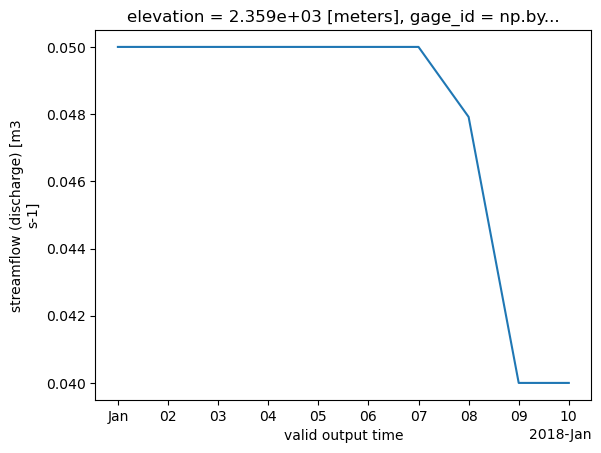

In [3]:
import xarray as xr
import fsspec
url = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/netcdf/daily_mean_2018.nc"
fs = fsspec.filesystem("gcs", anon=True) # anon=True since this is a public bucket
f = fs.open(url, mode="rb") # Open file
ds = xr.open_dataset(f)  # lazy load
subset = ds.isel(feature_id=1).sel(time=slice("2018-01-01", "2018-01-10"))
subset["streamflow"].plot()
f.close() # close the file when you're completely done

## Zarr file

I will also upload a Zarr as this will be more efficient for cloud computing. It will make it easy to lazy load in all the data and work efficiently with it in one large data cube with all years. Because our netcdfs have metadata and attributes, that will also be in the Zarr.

### Lazy load in all the netcdf files


In [4]:
import xarray as xr

ds = xr.open_mfdataset(
    "../netcdf/daily_mean_*.nc",
    combine="by_coords",
    parallel=True,
    chunks={}  # let the files load first, we'll rechunk explicitly
)

# Rechunk to Zarr-compatible layout
ds = ds.chunk({
    "feature_id": 5000,
    "time": 365  # uniform chunks except last chunk (Zarr requirement)
})

In [5]:
# double check the chunking. Should be yearly with 5000 feature_ids
ds.chunks

Frozen({'time': (365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 12), 'feature_id': (5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 2880)})

In [6]:
# Auth for GCS
import gcsfs
fs = gcsfs.GCSFileSystem(token="/home/jovyan/.config/gcloud/application_default_credentials.json")
zarr_path = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/zarr"
ds.to_zarr(
    zarr_path,
    storage_options={"token": "/home/jovyan/.config/gcloud/application_default_credentials.json"},
    mode="w",
    consolidated=True
)
print("Zarr uploaded to GCS!")

Zarr uploaded to GCS!


### Lazy loading the Zarr file

Test that we can load our Zarr.

In [7]:
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

import xarray as xr
zarr_url = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/zarr"
ds = xr.open_zarr(zarr_url, consolidated=True)
ds

<xarray.Dataset> Size: 43GB
Dimensions:     (time: 16072, feature_id: 332880)
Coordinates:
    elevation   (feature_id) float32 1MB dask.array<chunksize=(5000,), meta=np.ndarray>
  * feature_id  (feature_id) int64 3MB 341095 341097 ... 948100739 948100740
    gage_id     (feature_id) |S15 5MB dask.array<chunksize=(5000,), meta=np.ndarray>
    latitude    (feature_id) float32 1MB dask.array<chunksize=(5000,), meta=np.ndarray>
    longitude   (feature_id) float32 1MB dask.array<chunksize=(5000,), meta=np.ndarray>
    order       (feature_id) int32 1MB dask.array<chunksize=(5000,), meta=np.ndarray>
  * time        (time) datetime64[ns] 129kB 1979-02-01 1979-02-02 ... 2023-02-01
Data variables:
    crs         (time) int64 129kB dask.array<chunksize=(365,), meta=np.ndarray>
    streamflow  (time, feature_id) float64 43GB dask.array<chunksize=(365, 5000), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                   CF-1.7 CF-1.8
    featureType:                   timeSeries
    geospatial_bounds:             polygon((-124.71197509765625 32.5421142578...
    geospatial_lat_max:            49.039241790771484
    geospatial_lat_min:            32.5421142578125
    geospatial_lon_max:            -109.7713394165039
    ...                            ...
    processed_by:                  Eli Holmes, NOAA Fisheries
    processing_notes:              Converted hourly to daily means using xarr...
    region:                        USGS Water Resource Region 18 (HUC-2 Regio...
    source_data:                   https://noaa-nwm-retrospective-3-0-pds.s3....
    summary:                       Derived from hourly NWM v3.0 streamflow da...
    title:                         Daily Mean Streamflow from NOAA NWM Retros...

In [11]:
# Do a check on the Zarr file
import xarray as xr
ds = xr.open_zarr("gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/zarr", consolidated=True)
ds["streamflow"].attrs.items()

dict_items([('description', 'Daily mean streamflow calculated from hourly NWM v3.0 streamflow. Missing values are NaN.'), ('grid_mapping', 'crs'), ('long_name', 'streamflow (discharge)'), ('standard_name', 'river_discharge'), ('units', 'm3 s-1')])

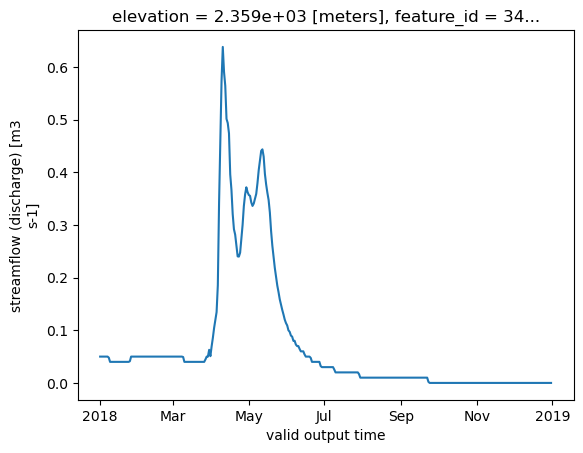

In [6]:
# Make a plot
subset = ds["streamflow"].sel(time="2018").isel(feature_id=1).plot();

Note if this were a private bucket you command to load would be
```
import xarray as xr

zarr_url = "gcs://nmfs_odp_nwfsc/CB/nwm_daily_means/wr1718/streamflow/zarr"

ds = xr.open_zarr(
    zarr_url,
    consolidated=True,
    storage_options={"token": "/home/jovyan/.config/gcloud/application_default_credentials.json"}
)
```


## Summary

We uploaded netcdf and Zarr directory to Google Cloud. Some workflows are based on downloading netcdf files, so I uploaded those but if you want to interact with the data by only getting the subsets that you need, then you will want to work with the Zarr files. Unfortunately, R tooling does not yet work well with Zarr files, but it is catching up.

## Extras deletng files

If you make a mistake.

In [9]:
import gcsfs

fs = gcsfs.GCSFileSystem(token="/home/jovyan/.config/gcloud/application_default_credentials.json")

bucket_prefix = "nmfs_odp_nwfsc/CB/nwm_daily_means/wr18"

# List all files under the prefix
files = fs.ls(bucket_prefix)

# Delete each file
for f in files:
    print(f"Deleting {f}")
    fs.rm(f, recursive=True)

print("✅ Folder deleted.")

FileNotFoundError: b/nmfs_odp_nwfsc/o/CB%2Fnwm_daily_means%2Fwr18